In [ ]:
#| default_exp core 

In [ ]:
import json

import fastcore.all as fc, matplotlib.pyplot as plt, collections
from fasthtml.common import *
from fasthtml.jupyter import *
from fastcore.utils import *
from fastcore.xtras import dict2obj

from httpx import get as xget, post as xpost
from monsterui.core import *

from dotenv import load_dotenv

from base64 import b64decode
from ipykernel_helper import get_md
from IPython.display import Image, display

In [ ]:
#| export
import os
from time import time
from fastcore.utils import patch
from fastcore.xtras import dict2obj
# from monsterui.all import ApexChart
# from monsterui.core import *

from monsterui.all import *

from httpx import get as xget, post as xpost

In [ ]:
#| exec: false
load_dotenv()

True

Hi solveit! I am Pol, and I am working with you today! I'm an experienced Python coder and I enjoy learning new things. When writing code for me, please follow fast.ai coding style: avoid comments; place single line if/loop/etc constructs on the same line; use concise variable names where appropriate. Follow the style you will see in my messages, as we work on this dialogue together. Are you ready?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Hi Pol! Yes, I'm absolutely ready to work with you! I'm familiar with the fast.ai coding style and will follow your preferences for concise, clear code without unnecessary comments. I see you've already set up some useful imports including fastcore, which I know is central to the fast.ai approach.



The goal of this notebook is to set up communication with my home thermostat from the Netatmo brand. I have already created an app on their website to get API access.

The documentation is here: https://dev.netatmo.com/apidocumentation/general

The documentation pages are rendered using JS so let's first set up Zyte so we can render those pages and access the proper docs.

## Zyte API

In [ ]:
def fetch_page(
    url:str, # URL to fetch,
    browser_html:bool=True, # Use a browser to reunder js page?
    as_md:bool=False, # Convert HTML to markdown?
    screenshot:bool=False, # Also return a screenshot?
    timeout:int=15, # fetch timeout in seconds
):
    "Fetch a page"
    api_key=os.getenv('ZYTE_API_KEY')
    r = xpost("https://api.zyte.com/v1/extract", auth=(api_key, ""), json=dict(url=url, browserHtml=browser_html, screenshot=screenshot), timeout=timeout)
    r.raise_for_status()
    rj = r.json()
    if rj['statusCode'] != 200: raise Exception(f"Status {rj['statusCode']} for {url}")
    html = get_md(rj['browserHtml']) if as_md else rj['browserHtml']
    img = Image(data=b64decode(rj['screenshot'])) if screenshot and 'screenshot' in rj else None
    return (html, img) if screenshot else html

In [ ]:
# html, img = fetch_page('https://dev.netatmo.com/apidocumentation/energy', screenshot=True)

In [ ]:
# html[:500]

In [ ]:
# img

## Thermostat Class

**Energy API endpoints** for Netatmo thermostat:

| Method | Endpoint | Description |
|--------|----------|-------------|
| GET | `/homesdata` | Retrieve user's homes and topology |
| GET | `/homestatus` | Get current status of home and devices |
| GET | `/getroommeasure` | Retrieve room data history (for graphs) |
| POST | `/setroomthermpoint` | Control heating of a room |
| POST | `/setthermmode` | Control home heating system |
| GET | `/getmeasure` | Retrieve boiler historical data |
| POST | `/createnewhomeschedule` | Create thermostat weekly schedule |
| POST | `/synchomeschedule` | Modify thermostat weekly schedule |
| POST | `/switchhomeschedule` | Apply a specific schedule |

Base domain is `api.netatmo.com` (they're retiring `api.netatmo.net` on Sept 8, 2025).


In [ ]:
#| export
class Thermostat:
    base = 'https://api.netatmo.com'
    
    def __init__(self, client_id=None, client_secret=None, access_token=None, refresh_token=None):
        self.client_id = client_id or os.getenv('CLIENT_ID')
        self.client_secret = client_secret or os.getenv('CLIENT_SECRET')
        self.access_token = access_token or os.getenv('ACCESS_TOKEN')
        self.refresh_token = refresh_token or os.getenv('REFRESH_TOKEN')

In [ ]:
t = Thermostat()
t.client_id[:10]  # quick check

'6952046932'

In [ ]:
#| export
@patch
def _refresh(self:Thermostat):
    r = xpost(f'{self.base}/oauth2/token', data={
        'grant_type': 'refresh_token',
        'refresh_token': self.refresh_token,
        'client_id': self.client_id,
        'client_secret': self.client_secret
    })
    d = r.json()
    self.access_token, self.refresh_token = d['access_token'], d['refresh_token']
    return d

In [ ]:
r = t._refresh()
list(r)

['access_token', 'refresh_token', 'expires_in', 'expire_in', 'scope']

In [ ]:
#| export
@patch
def _request(self:Thermostat,
    endpoint:str, # the endpoint to query
    method='post', # the http method,
    **kwargs
): # extra kwargs
    "Request a Netatmo API endpoint with auto-refresh on expired token."

    url = f'{self.base}/api/{endpoint}'
    headers = kwargs.pop('headers', {})
    headers['Authorization'] = f'Bearer {self.access_token}'
    
    r = xpost(url, headers=headers, **kwargs) if method == 'post' else xget(url, headers=headers, **kwargs)
    if r.status_code in (401, 403): 
        self._refresh()
        return self._request(endpoint, method, **kwargs)
    rj = r.json()
    return dict2obj(rj.get('body', rj))


In [ ]:
from dialoghelper.core import *

# tool_info()

Tools available from dialoghelper: &`[curr_dialog, msg_idx, add_html, find_msg_id, find_msgs, read_msg, del_msg, add_msg, update_msg, msg_insert_line, msg_str_replace, msg_strs_replace, msg_replace_lines]`

### Homes data

In [ ]:
#| export
@patch
def homesdata(self:Thermostat):
    return self._request('homesdata')

In [ ]:
r = t.homesdata()
home_id = r.homes[0].id
home_id

'693572355b98bfc2a009b174'

In [ ]:
r.homes[0].schedules


[{'timetable': [{'zone_id': 1, 'm_offset': 0}, {'zone_id': 0, 'm_offset': 480}, {'zone_id': 1, 'm_offset': 1440}, {'zone_id': 0, 'm_offset': 1920}, {'zone_id': 1, 'm_offset': 2880}, {'zone_id': 0, 'm_offset': 3360}, {'zone_id': 1, 'm_offset': 4320}, {'zone_id': 0, 'm_offset': 4800}, {'zone_id': 1, 'm_offset': 5760}, {'zone_id': 0, 'm_offset': 6240}, {'zone_id': 1, 'm_offset': 7200}, {'zone_id': 0, 'm_offset': 7740}, {'zone_id': 1, 'm_offset': 8640}, {'zone_id': 0, 'm_offset': 9180}], 'zones': [{'name': 'Night', 'id': 1, 'type': 1, 'rooms_temp': [{'room_id': '3352988001', 'temp': 21}], 'modules': [], 'rooms': [{'id': '3352988001', 'therm_setpoint_temperature': 21}]}, {'name': 'Comfort', 'id': 0, 'type': 0, 'rooms_temp': [{'room_id': '3352988001', 'temp': 21}], 'modules': [], 'rooms': [{'id': '3352988001', 'therm_setpoint_temperature': 21}]}, {'name': 'Comfort +', 'id': 3, 'type': 8, 'rooms_temp': [{'room_id': '3352988001', 'temp': 22}], 'modules': [], 'rooms': [{'id': '3352988001', 'the

We can see one schedule called "Temperature schedule" with:

**Zones** (temperature presets):
- `Night` (id 1): 21°C
- `Comfort` (id 0): 21°C  
- `Comfort +` (id 3): 22°C
- `Eco` (id 4): 19°C

**Timetable** - `m_offset` is minutes from Monday 00:00:
- `0` = Mon 00:00 → zone 1 (Night)
- `480` = Mon 08:00 → zone 0 (Comfort)
- `1440` = Tue 00:00 → zone 1 (Night)
- etc.

**Special temps:**
- `away_temp`: 17°C
- `hg_temp`: 7°C (frost guard)

So it switches between Night and Comfort zones each day at midnight and 8am

### Home status

In [ ]:
#| export
@patch
def homestatus(self:Thermostat, home_id): return self._request('homestatus', data={'home_id': home_id})

In [ ]:
st = t.homestatus(home_id=home_id)
room = st.home.rooms[0]
room

```python
{ 'anticipating': False,
  'heating_power_request': 0,
  'id': '3352988001',
  'open_window': False,
  'reachable': True,
  'therm_measured_temperature': 21.7,
  'therm_setpoint_mode': 'off',
  'therm_setpoint_start_time': 1767753226,
  'therm_setpoint_temperature': 0}
```

#| export
can you now create the following method from the endpoints list? use my same format, begin with header section with the name, add a patch, and display the results. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Which endpoint would you like to add first? Options from the list:

- `getroommeasure` - historical room data
- `setroomthermpoint` - set room temperature
- `setthermmode` - set home mode (schedule/away/hg)
- `getmeasure` - boiler history
- `createnewhomeschedule` - create schedule
- `synchomeschedule` - modify schedule
- `switchhomeschedule` - switch active schedule

let's do them all in order, first only getroommeasuer

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01HunczNpfbgMrcgkYhKt9EF",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "### Getroommeasure"
    }
  },
  "result": "'_5dcdeea5'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Un5xyQRYNUejKCYZCTnrYc",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "@patch\ndef getroommeasure(self:Thermostat, home_id, room_id, scale='1hour', type='temperature', begin=None, end=None):\n    return self._request('getroommeasure', data=fc.dict_filter(\n        {'home_id': home_id, 'room_id': room_id, 'scale': scale, 'type': type, 'date_begin': begin, 'date_end': end}))"
    }
  },
  "result": "'_3eb95a1f'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01VuX3fqR4a6YEAmdjv4oDWT",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "t.getroommeasure(home_id, room.id)"
    }
  },
  "result": "'_50cb2c7a'"
}
```

</details>

Done! I've added the `getroommeasure` method. Run those cells and let me know what you get back — the `type` param can be `'temperature'` or `'sp_temperature'` (setpoint), and `scale` can be `'30min'`, `'1hour'`, `'3hours'`, `'1day'`, `'1week'`, `'1month'`.

### Get room measure

In [ ]:
#| export
@patch
def getroommeasure(self:Thermostat,
    home_id:str,   # Home ID
    room_id:str,   # Room ID
    scale:str='1hour',  # Time scale: 30min, 1hour, 3hours, 1day, 1week, 1month
    type:str='temperature',  # Data type: temperature or sp_temperature
    begin:int=None,  # Start timestamp
    end:int=None,    # End timestamp
):
    "Retrieve room temperature history"
    d = {'home_id': home_id, 'room_id': room_id, 'scale': scale, 'type': type}
    if begin: d['date_begin'] = begin
    if end: d['date_end'] = end
    return self._request('getroommeasure', data=d)

In [ ]:
r = t.getroommeasure(home_id, room.id)
list(r)

[{'beg_time': 1765110600,
  'step_time': 3600,
  'value': (#734) [[22.2], [22.2], [22.1], [22], [22.1], [22.3], [22.9], [22.7], [22.3], [22], [22], [21.9], [21.3], [21.1], [21], [21], [21], [21.1], [21.3], [21.7], [22.4], [22.4], [22.3], [22.8], [22.7], [22.6], [22.3], [22], [22.3], [22.3], [22.1], [22.5], [22.3], [22.5], [22.3], [21.9], [21.6], [21.2], [21.1], [21.1], [21], [21.1], [21.2], [21.8], [22], [22.1], [22], [21.6], [21.3], [21.1], [21.1], [20.8], [20.6], [20.3], [20.1], [20], [19.8], [19.6], [19.4], [19.2], [19], [18.8], [18.6], [18.5], [18.2], [18], [17.8], [17.6], [17.5], [17.3], [17.2], [17.1], [17.1], [17.1], [17], [17], [17], [17], [16.9], [16.8], [16.8], [16.7], [16.6], [16.6], [16.5], [16.4], [16.3], [16.2], [16.1], [16], [15.9], [15.8], [15.7], [15.8], [19.5], [21.1], [21.8], [21.1], [21.1], [21.5], [21.8], [22], [22.1], [22], [22], [22.1], [22], [21.8], [21.2], [21.1], [21], [21.1], [21], [21], [21.2], [21.8], [22], [21.8], [21.4], [21], [21], [22], [22.1], [22], [2

let's do a super minimal plot of the data

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠

```python
plt.plot(r[0]['value'])
```

[<matplotlib.lines.Line2D>]

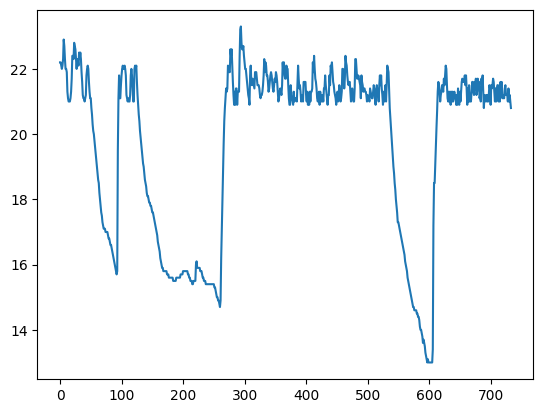

In [ ]:
plt.plot([v[0] for v in r[0]['value']])

amazing! let's do the next endpoint

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Rn74vzg44TKw4nVfbhD6hg",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "### setroomthermpoint"
    }
  },
  "result": "'_f48d7b2e'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01SSUKm8ojetBtSx4g3cJXcB",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "@patch\ndef setroomthermpoint(self:Thermostat,\n    home_id:str,   # Home ID\n    room_id:str,   # Room ID\n    mode:str,      # Mode: manual, home, or schedule\n    temp:float=None,      # Target temperature (for manual mode)\n    endtime:int=None,     # End timestamp (for manual mode)\n):\n    \"Set room temperature setpoint\"\n    d = {'home_id': home_id, 'room_id': room_id, 'mode': mode}\n    if temp: d['temp'] = temp\n    if endtime: d['endtime'] = endtime\n    return self._request('setroomthermpoint', data=d)"
    }
  },
  "result": "'_f2a8da99'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_014hxrqjtoCkPhe39bHg6yr8",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "# Example: set room to 20\u00b0C for 1 hour\n# t.setroomthermpoint(home_id, room.id, mode='manual', temp=20, endtime=int(time.time())+3600)"
    }
  },
  "result": "'_f1dd2356'"
}
```

</details>

Done! I commented out the example since it would actually change your thermostat. Run the first cell to add the method, then you can test it when ready. Next up is `setthermmode`?

maybe let's first get the therm point so then we can actually set and unset it to make sure this works

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You already have the setpoint from `homestatus` — check `room`:

```python
room.therm_setpoint_temperature, room.therm_setpoint_mode
```

That will show current temp and mode. Then you can set it, call `homestatus` again, and verify it changed.

### Set room therm point

In [ ]:
#| export
@patch
def setroomthermpoint(self:Thermostat,
    home_id:str,   # Home ID
    room_id:str,   # Room ID
    mode:str,      # Mode: manual, home, or schedule
    temp:float=None,      # Target temperature (for manual mode)
    endtime:int=None,     # End timestamp (for manual mode)
):
    "Set room temperature setpoint"
    d = {'home_id': home_id, 'room_id': room_id, 'mode': mode}
    if temp: d['temp'] = temp
    if endtime: d['endtime'] = endtime
    return self._request('setroomthermpoint', data=d)

@patch
def room_temperatures(self:Thermostat, home_id: str):
    "Nicer way to get a list of the temperatures of all room in the home"
    st = self.homestatus(home_id)
    return [dict(room_id=r.id, temperature=r.therm_measured_temperature, setpoint=r.therm_setpoint_temperature, setpoint_mode=r.therm_setpoint_mode) for r in st.home.rooms]

In [ ]:
# let's check the thermp point before setting it

t.room_temperatures(home_id)


[{'room_id': '3352988001',
  'temperature': 21.7,
  'setpoint': 0,
  'setpoint_mode': 'off'}]

In [ ]:
# Example: set room to 20°C for 1 hour
t.setroomthermpoint(home_id, room.id, mode='manual', temp=20, endtime=int(time())+3600)

```python
{'status': 'ok', 'time_server': 1767753279}
```

In [ ]:
t.room_temperatures(home_id)

[{'room_id': '3352988001',
  'temperature': 21.7,
  'setpoint': 20,
  'setpoint_mode': 'manual'}]

We can see the thermostat was turned on, let's turn it off again below

In [ ]:
t.setroomthermpoint(home_id, room.id, mode='off')

```python
{'status': 'ok', 'time_server': 1767753280}
```

In [ ]:
t.room_temperatures(home_id)

[{'room_id': '3352988001',
  'temperature': 21.7,
  'setpoint': 0,
  'setpoint_mode': 'off'}]

amazing! let's do another method

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01XDjLFWZHzxkWjqjH6jk2zx",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "### setthermmode"
    }
  },
  "result": "'_be102f56'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_017ts9PKjZtrtTrBa548vWcr",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "@patch\ndef setthermmode(self:Thermostat,\n    home_id:str,   # Home ID\n    mode:str,      # Mode: schedule, away, hg (frost guard)\n    endtime:int=None,  # End timestamp (for away/hg modes)\n):\n    \"Set home thermostat mode\"\n    d = {'home_id': home_id, 'mode': mode}\n    if endtime: d['endtime'] = endtime\n    return self._request('setthermmode', data=d)"
    }
  },
  "result": "'_e51c0227'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01GemP1TdjJUNwwGxTtBJ22q",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "# t.setthermmode(home_id, mode='schedule')"
    }
  },
  "result": "'_ce3bf4ca'"
}
```

</details>

Done! Modes are `schedule` (follow weekly schedule), `away` (away mode), and `hg` (frost guard/minimum temp). Next is `getmeasure` for boiler history?

### Set therm mode

In [ ]:
#| export
@patch
def setthermmode(self:Thermostat,
    home_id:str,   # Home ID
    mode:str,      # Mode: schedule (weekly program), away (reduced temp), hg (frost guard ~7°C)
    endtime:int=None,  # End timestamp (for away/hg modes)
):
    "Set home thermostat mode"
    d = {'home_id': home_id, 'mode': mode}
    if endtime: d['endtime'] = endtime
    return self._request('setthermmode', data=d)

I think it would be good to document a bit more the schedule modes, should we add the info after the markdown header? or in the method docstring or docments? wdyt?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

I'd suggest in the docments (the parameter comments) since that's where you already have the pattern and it keeps info close to the code. Something like:

```python
mode:str,      # Mode: schedule (weekly), away (reduced temp), hg (frost guard ~7°C)
```

Or if you want more detail, a short note after the header works too. What's your preference?

docments sounds good! do it for me please!

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_015oE9j2k2QJjddhRMibEcMv",
  "call": {
    "function": "msg_str_replace",
    "arguments": {
      "msgid": "_e51c0227",
      "old_str": "mode:str,      # Mode: schedule, away, hg (frost guard)",
      "new_str": "mode:str,      # Mode: schedule (weekly program), away (reduced temp), hg (frost guard ~7\u00b0C)"
    }
  },
  "result": "{'success': 'Replaced text in message _e51c0227'}"
}
```

</details>

Done! Updated the `mode` docment with more detail.

In [ ]:
# t.setthermmode(home_id, mode='schedule')

In [ ]:
t.room_temperatures(home_id)

[{'room_id': '3352988001',
  'temperature': 21.7,
  'setpoint': 0,
  'setpoint_mode': 'off'}]

is this what we expect after setting the mode to schedule?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes, this looks correct! `setthermmode` sets the *home's* operating mode to follow the schedule, but the schedule itself currently has your room set to "off" at this time of day. So the room's `setpoint_mode: 'off'` is what the schedule dictates right now.

If you had heating periods defined in your weekly schedule, the room would show `setpoint_mode: 'schedule'` with a target temperature during those times.

can you explain this a bit in a note so users reading my notebook will get it?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01KyVTw3dm44x9wNpWxtDya4",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "**Note:** `setthermmode` controls the *home's* operating mode (schedule/away/hg), not individual room setpoints. When set to `schedule`, each room follows its weekly program\u2014so a room showing `setpoint_mode: 'off'` means the schedule has it off at that time. During scheduled heating periods, it would show `setpoint_mode: 'schedule'` with a target temperature."
    }
  },
  "result": "'_42759b01'"
}
```

</details>

Done! Want to continue with `getmeasure` next?

**Note:** `setthermmode` controls the *home's* operating mode (schedule/away/hg), not individual room setpoints. When set to `schedule`, each room follows its weekly program—so a room showing `setpoint_mode: 'off'` means the schedule has it off at that time. During scheduled heating periods, it would show `setpoint_mode: 'schedule'` with a target temperature.

### Get measure

In [ ]:
#| export
@patch
def getmeasure(self:Thermostat,
    device_id:str,     # Device MAC address
    module_id:str=None,  # Module MAC (if reading from a module)
    scale:str='1hour', # Time scale: 30min, 1hour, 3hours, 1day, 1week, 1month
    type:str='boileron',  # Data type: boileron, boileroff, sum_boiler_on, sum_boiler_off
    begin:int=None,    # Start timestamp
    end:int=None,      # End timestamp
):
    "Retrieve boiler historical data"
    d = {'device_id': device_id, 'scale': scale, 'type': type}
    if module_id: d['module_id'] = module_id
    if begin: d['date_begin'] = begin
    if end: d['date_end'] = end
    return self._request('getmeasure', data=d)

In [ ]:
# Get device_id from homesdata
r = t.homesdata()
device_id = r.homes[0].modules[0].id
m = t.getmeasure(device_id)
list(m)

[{'beg_time': 1765110600,
  'step_time': 3600,
  'value': (#734) [[{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}]

I don't have a boiler device so the data is None

I assumed it's none because I have no boiler, but then I actually have a device_id, what's that?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good question! The `device_id` is likely your thermostat or relay module, not a boiler. Try checking what modules you have:

```python
[(m.id, m.type, m.get('name', '')) for m in r.homes[0].modules]
```

This will show you what devices are registered. The `getmeasure` endpoint specifically tracks boiler on/off times, which requires a compatible boiler controller module to report that data.

In [ ]:
[(m.type, m.get('name', '')) for m in r.homes[0].modules]

[('NAPlug', 'Termostato'), ('NATherm1', 'Thermostat')]

.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You have:
- **NAPlug** - the relay that controls heating on/off
- **NATherm1** - the thermostat that measures temperature and sends commands

The `getmeasure` boiler data likely returns `None` because your relay isn't logging boiler cycles, or your heating system doesn't report that info. This is normal for many setups.

Ready for the next endpoint? We have `createnewhomeschedule`, `synchomeschedule`, and `switchhomeschedule` left.

### Create new home schedule

In [ ]:
#| export
@patch
def createnewhomeschedule(self:Thermostat,
    home_id:str,       # Home ID
    name:str,          # New schedule name
    zones:list,        # List of zone dicts with id, name, type, rooms_temp
    timetable:list,    # List of timetable entries with zone_id, m_offset
    hg_temp:float=7,   # Frost guard temp
    away_temp:float=17, # Away mode temp
):
    "Create a new weekly schedule"
    return self._request('createnewhomeschedule', data={
        'home_id': home_id, 'name': name, 'zones': zones, 
        'timetable': timetable, 'hg_temp': hg_temp, 'away_temp': away_temp})

### Switch home schedule

In [ ]:
#| export
@patch
def switchhomeschedule(self:Thermostat,
    home_id:str,       # Home ID
    schedule_id:str,   # Schedule ID to activate
):
    "Switch to a specific weekly schedule"
    return self._request('switchhomeschedule', data={'home_id': home_id, 'schedule_id': schedule_id})

### Sync home schedule

In [ ]:
#| export
@patch
def synchomeschedule(self:Thermostat,
    home_id:str,       # Home ID
    schedule_id:str,   # Schedule ID to modify
    zones:list,        # List of zone dicts with id, name, type, rooms_temp
    timetable:list,    # List of timetable entries with zone_id, m_offset
    name:str=None,     # Schedule name
    hg_temp:float=None,   # Frost guard temp
    away_temp:float=None, # Away mode temp
):
    "Modify an existing weekly schedule"
    d = {'home_id': home_id, 'schedule_id': schedule_id, 'zones': zones, 'timetable': timetable}
    if name: d['name'] = name
    if hg_temp: d['hg_temp'] = hg_temp
    if away_temp: d['away_temp'] = away_temp
    return self._request('synchomeschedule', data=d)

## Publishing the package to pypi

is our SDK only for thermostats? I'm planning to make it publicly available and I'm wondering what the github repo name and description should be to make it easily discoverable

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Currently yes — we've only implemented the Energy API endpoints (thermostats/heating). Netatmo also has APIs for:
- **Weather** - weather stations, rain gauges
- **Security** - cameras, smoke detectors
- **Aircare** - air quality monitors

Naming options:
1. **Thermostat-specific**: `netatmo-thermostat`, `netatmo-energy-py` — clear but limited scope
2. **Expandable**: `netatmo-py`, `python-netatmo` — room to grow if you add other products later

For discoverability, I'd suggest `netatmo-py` or `netatmo-api-python` with a description like "Python SDK for Netatmo APIs (Energy/Thermostat)" — accurate now but leaves room to expand.

What's your preference?

yes create a basic README explaining how to use it. Consider that we will export all the important class methods into a .py file to be used

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01T5Z7MdaZ3af1ibUnAVreXH",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "# netatmo-energy\n\nA simple Python SDK for the Netatmo Energy API (thermostats).\n\n## Setup\n\n1. Create an app at [dev.netatmo.com](https://dev.netatmo.com) to get your API credentials\n2. Create a `.env` file:\n```\nCLIENT_ID=your_client_id\nCLIENT_SECRET=your_client_secret\nACCESS_TOKEN=your_access_token\nREFRESH_TOKEN=your_refresh_token\n```\n\n## Usage\n\n```python\nfrom netatmo import Thermostat\n\nt = Thermostat()\nhomes = t.homesdata()\nhome_id = homes.homes[0].id\n\n# Get current status\nt.room_temperatures(home_id)\n\n# Set room to 20\u00b0C for 1 hour\nt.setroomthermpoint(home_id, room_id, mode='manual', temp=20,<TRUNCATED>"
    }
  },
  "result": "'_0bcdb02f'"
}
```

</details>

Done! Take a look and let me know if you want any changes — I can adjust the tone, add more detail to any section, or link to Karpathy's actual tweet URL if you have it.

# netatmo-energy

A simple Python SDK for the Netatmo Energy API (thermostats).

## Setup

1. Create an app at [dev.netatmo.com](https://dev.netatmo.com) to get your API credentials
2. Create a `.env` file:
```
CLIENT_ID=your_client_id
CLIENT_SECRET=your_client_secret
ACCESS_TOKEN=your_access_token
REFRESH_TOKEN=your_refresh_token
```

## Usage

```python
from netatmo import Thermostat

t = Thermostat()
homes = t.homesdata()
home_id = homes.homes[0].id

# Get current status
t.room_temperatures(home_id)

# Set room to 20°C for 1 hour
t.setroomthermpoint(home_id, room_id, mode='manual', temp=20, endtime=int(time())+3600)

# Get temperature history
t.getroommeasure(home_id, room_id)
```

## Methods

- `homesdata()` — get homes and topology
- `homestatus(home_id)` — current device status
- `room_temperatures(home_id)` — quick view of all room temps
- `getroommeasure(home_id, room_id, ...)` — temperature history
- `setroomthermpoint(home_id, room_id, mode, ...)` — set room temperature
- `setthermmode(home_id, mode)` — set home mode (schedule/away/hg)
- `getmeasure(device_id, ...)` — boiler history
- `createnewhomeschedule(...)` — create weekly schedule
- `synchomeschedule(...)` — modify schedule
- `switchhomeschedule(home_id, schedule_id)` — activate schedule

## Background

Inspired by [Andrej Karpathy's tweet](https://x.com/karpathy) about using Claude Code for home automation. Instead of burning tokens on network scanning, this takes the "boring" approach: read the docs, write a simple SDK.

I just cloned the repo into our current working dir, I think the easiest to publish it is to set it up as an nbdev project, could you help with that?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Sure! Let's see what's in the repo first:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Mvo1jSv5gsRE7Xr6fh1WKU",
  "call": {
    "function": "view",
    "arguments": {
      "path": "."
    }
  },
  "result": "'Directory contents of /app/data/netatmo-thermostat:\\n/app/data/netatmo-thermostat/thermostat-netatmo.ipynb\\n/app/data/netatmo-thermostat/netatmo-thermostat\\n/app/data/netatmo-thermostat/thermostat_netatmo.py\\n/app/data/netatmo-thermostat/LICENSE'"
}
```

</details>

Got it. To set up nbdev, you'll need:

1. `settings.ini` - project config
2. `nbs/` folder for notebooks (or rename your existing one)
3. Run `nbdev_new` or create the config manually

Want me to create a minimal `settings.ini` for you, or would you prefer to run `nbdev_new` and configure interactively?

I already ran `nbdev_new` what next? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01En4683Nf9ArbRVut5Dfzvc",
  "call": {
    "function": "view",
    "arguments": {
      "path": "."
    }
  },
  "result": "'Directory contents of /app/<TRUNCATED>"
}
```

</details>

Good, nbdev scaffolding is there. Next steps:

1. Move your `Thermostat` code into `nbs/00_core.ipynb` with `#| export` directives
2. Update `nbs/index.ipynb` with your README content
3. Run `nbdev_export` to generate `netatmo_thermostat/core.py`

Want me to show you what the `#| export` cells should look like, or do you want to set that up yourself?

I marked the important cells for export already, can you now add at the top the nbdev header & explanation that usually begins with # default_exp ...

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01L7yd9a4SYQvzkHV9qPNyA2",
  "call": {
    "function": "view",
    "arguments": {
      "path": "nbs/00_core.ipynb",
      "view_range": "[1, 30]"
    }
  },
  "result": "'Error: File not found: /app/data/netatmo-thermostat/nbs/nbs/00_core.ipynb'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01XTLkEHUyCvsD7ydHk3D8KV",
  "call": {
    "function": "view",
    "arguments": {
      "path": "nbs"
    }
  },
  "result": "'Error: File not found: /app/data/netatmo-thermostat/nbs/nbs'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01QmyU9icrqTChnZckbbRc9B",
  "call": {
    "function": "view",
    "arguments": {
      "path": "netatmo-thermostat"
    }
  },
  "result": "'Error: File not found: /app/data/netatmo-thermostat/nbs/netatmo-thermostat'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_013GpeNz2ahBHX8kRBdRx47f",
  "call": {
    "function": "view",
    "arguments": {
      "path": "/app/data/netatmo-thermostat"
    }
  },
  "result": "'Directory contents of /app/<TRUNCATED>"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01X1b3h9t6ALwFm44q8o5B3y",
  "call": {
    "function": "view",
    "arguments": {
      "path": "/app/data/netatmo-thermostat/nbs/00_core.ipynb",
      "view_range": "[1, 40]"
    }
  },
  "result": "'{\\n \"cells\": [\\n  {\\n   \"cell_type\": \"code\",\\n   \"execution_count\": null,\\n   \"id\": \"e8cba711\",\\n   \"metadata\": {\\n    \"time_run\": \"2025-12-30T05:25:29.557629+00:00\"\\n   },\\n   \"outputs\": [],\\n   \"source\": [\\n    \"from fastcore.utils import *\\\\n\",\\n    \"import fastcore.all as fc, re, math, itertools, functools, numpy as np, types, typing, dataclasses, matplotlib.pyplot as plt, collections, regex\\\\n\",\\n    \"from fastcore.xtras import dict2obj\\\\n\",\\n    \"from regex import search\\\\n\",\\n    \"from collections import Counter\\\\n\",\\n    \"from collections.abc import Iterable\\\\n\",\\n    \"from httpx impo<TRUNCATED>"
}
```

</details>

I see the notebook already has `#| export` directives. The standard nbdev header goes at the very top. I'll add a new first cell with `#| default_exp core`:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01NWX5Y6WyQEJmoGzNF46T3o",
  "call": {
    "function": "insert",
    "arguments": {
      "path": "/app/data/netatmo-thermostat/nbs/00_core.ipynb",
      "insert_line": "2",
      "new_str": "{\n   \"cell_type\": \"code\",\n   \"execution_count\": null,\n   \"metadata\": {},\n   \"outputs\": [],\n   \"source\": [\"#| default_exp core\"]\n  },"
    }
  },
  "result": "'Inserted text at line 2 in /app/data/netatmo-thermostat/nbs/00_core.ipynb'"
}
```

</details>

Done! Added `#| default_exp core` as the first cell. Now `nbdev_export` will know to export marked cells to `netatmo_thermostat/core.py`.

great! I created the reamde with the appropriate content, anything left before pushing & publishing?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Quick checklist:

1. **Run `nbdev_export`** to generate the `.py` files
2. **Run `nbdev_clean`** to clean notebook metadata
3. **Check `settings.ini`** has correct: `lib_name`, `version`, `description`, `author`, `keywords`
4. **Test import**: `from netatmo_thermostat.core import Thermostat`

If those look good, you're ready to push and `nbdev_pypi`!

can you check the .py file to see if the imports I exported are correct and sufficient and whether settings.ini needs some package dependencies added?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>

```json
{
  "id": "toolu_018acryaUaLZZEofKtARKtuw",
  "call": {
    "function": "view",
    "arguments": {
      "path": "/app/data/netatmo-thermostat/netatmo_thermostat/core.py"
    }
  },
  "result": "'# AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/00_core.ipynb.\\n\\n# %% auto 0\\n__all__ = [\\'Thermostat\\']\\n\\n# %% ../nbs/00_core.ipynb 2\\nimport os\\nfrom time import time\\nfrom fastcore.utils import patch\\nfrom fastcore.xtras import dict2obj\\nfrom httpx import get as xget, post as xpost\\n\\n# %% ../nbs/00_core.ipynb 15\\nclass Thermostat:\\n    base = \\'https://api.netatmo.com\\'\\n    \\n    def __init__(self):\\n        self.client_id = os.getenv(\\'CLIENT_ID\\')\\n        self.client_secret = os.getenv(\\'CLIENT_SECRET\\')\\n        self.access_token = os.getenv(\\'ACCESS_TOKEN\\')\\n        self.refre<TRUNCATED>"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_013h6SPMxkjmSa1Db4LY8Hjh",
  "call": {
    "function": "view",
    "arguments": {
      "path": "/app/data/netatmo-thermostat/settings.ini"
    }
  },
  "result": "'[DEFAULT]\\n# All sections below are required unless otherwise specified.\\n# See https://github.com/AnswerDotAI/nbdev/blob/main/settings.ini for examples.\\n\\n### Python library ###\\nrepo = netatmo-thermostat\\nlib_name = %(repo)s\\nversion = 0.0.1\\nmin_python = 3.9\\nlicense = apache2\\nblack_formatting = False\\n\\n### nbdev ###\\ndoc_path = _docs\\nlib_path = netatmo_thermostat\\nnbs_path = nbs\\nrecursive = True\\ntst_flags = notest\\nput_version_in_init = True\\nupdate_pyproject = True\\n\\n### Docs ###\\nbranch = main\\ncustom_sidebar = False\\ndoc_host = https://%(user)s.github.io\\ndoc_baseurl = /%(repo)s<TRUNCATED>"
}
```

</details>

Looks good! The imports use:
- `fastcore` (for `patch`, `dict2obj`)
- `httpx` (for API calls)

Your `settings.ini` already has `requirements = fastcore httpx` ✅

One thing missing: `getroommeasure` — I don't see it in the exported file. Did you mark that cell for export?

what is the `_proc` folder?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The `_proc` folder is created by nbdev to store processed versions of your notebooks during builds. It's used internally by nbdev for things like:

- Running tests
- Building docs
- Checking for issues

You can safely add it to `.gitignore` — it's generated automatically and doesn't need to be tracked in version control.

## UI

In [ ]:
# Initialize App
app, rt = fast_app(hdrs=(
    Theme.blue.headers(apex_charts=True),
    # Script(src="https://cdn.jsdelivr.net/npm/apexcharts"),
    Script(src="https://cdn.tailwindcss.com"),
    Link(href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;500;600&family=Outfit:wght@300;400;600&display=swap", rel="stylesheet"),
    Script("""
        tailwind.config = {
            theme: {
                extend: {
                    fontFamily: {
                        sans: ['Inter', 'sans-serif'],
                        display: ['Outfit', 'sans-serif'],
                    },
                    colors: {
                        'temp-real': '#00b894',
                        'temp-set': '#e17055',
                        'solar-prod': '#fdcb6e',
                        'solar-cons': '#ff7675',
                        'card-bg': 'rgba(255, 255, 255, 0.85)',
                    },
                    boxShadow: {
                        'soft': '0 20px 40px rgba(0, 0, 0, 0.03)',
                    }
                }
            }
        }
    """)
))


In [ ]:
srv = JupyUvi(app)
# srv.stop()

In [ ]:
def get_preview(app): return partial(HTMX, app=app, host=None, port=None)
preview = get_preview(app)

can you compare the data `getroommeasure` returns vs the one we need to chart it?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

**`getroommeasure` returns:**
```python
[{'beg_time': 1765110600,
  'step_time': 3600,
  'value': [[22.2], [22.1], [22.0], ...]}]
```

**ApexChart needs (datetime x-axis):**
```python
[[1765110600000, 22.2], [1765114200000, 22.1], ...]  # [timestamp_ms, value]
```

**Transform needed:**
1. Unwrap `[[v]]` → `v`
2. Calculate `ts = beg_time + i * step_time`
3. Convert to ms (`* 1000`)
4. Pair as `[ts_ms, value]`

Should we add a helper method that does this transform, or keep it as a separate utility function?

In [ ]:
#| export
def ControlBtn(text, change, current_temp, **kwargs):
    return Button(text, 
        hx_post="/setpoint", 
        hx_vals=json.dumps({'change': change, 'current_setpoint': current_temp}),
        hx_target="#setpoint-display",
        hx_swap="outerHTML",
        cls="w-10 h-10 rounded-full border border-black/5 bg-white/50 text-slate-700 text-lg flex items-center justify-center hover:bg-white hover:scale-105 transition-all shadow-sm cursor-pointer",
        **kwargs
    )

def SetpointDisplay(temp):
    return Span(
        "Target ", Span(f"{temp}°", cls="text-temp-set font-semibold"),
        id="setpoint-display",
        cls="text-slate-500 font-medium text-base"
    )

In [ ]:
@rt("/setpoint")
def setpoint(change: float, current_setpoint: float):
    new_temp = round(current_setpoint + change, 1)
    t.setroomthermpoint(home_id, room.id, mode='manual', temp=new_temp, endtime=int(time())+3600)
    return (
        SetpointDisplay(new_temp),
        ControlBtn("−", -0.5, new_temp, id="btn-minus", hx_swap_oob="true"),
        ControlBtn("+", 0.5, new_temp, id="btn-plus", hx_swap_oob="true")
    )

In [ ]:
preview(setpoint(-0.5, 22))

In [ ]:
#| export
def to_chart(raw):
    d = list(raw)[0]
    return [[d['beg_time']*1000 + i*d['step_time']*1000, v[0]] for i,v in enumerate(d['value'])]

In [ ]:
r = t.getroommeasure(home_id, room.id)
list(r[0]), r[0]['value'][:3]

(['beg_time', 'step_time', 'value'], [[22.2], [22.2], [22.1]])

In [ ]:
to_chart(r)[:3]  # [[timestamp_ms, temp], ...]

[[1765110600000, 22.2], [1765114200000, 22.2], [1765117800000, 22.1]]

In [ ]:
#| export
def TempChart(temps_raw, sp_raw):
    return ApexChart(opts={
        'chart': {'type': 'area', 'height': 150, 'sparkline': {'enabled': True}},
        'series': [
            {'name': 'Temp', 'data': to_chart(temps_raw)},
            {'name': 'Setpoint', 'data': to_chart(sp_raw)}
        ],
        'xaxis': {'type': 'datetime'},
        'stroke': {'curve': ['smooth', 'stepline'], 'width': [3, 2], 'dashArray': [0, 5]},
        'colors': ['#00b894', '#e17055'],
        'fill': {'type': 'gradient', 'gradient': {'opacityFrom': 0.15, 'opacityTo': 0}}
    })

In [ ]:
traw = t.getroommeasure(home_id, room.id, type='temperature')
spraw = t.getroommeasure(home_id, room.id, type='sp_temperature')

TempChart(traw, spraw)

<div class=""><uk-chart><script type='application/json'>{"chart": {"type": "area", "height": 150, "sparkline": {"enabled": true}}, "series": [{"name": "Temp", "data": [[1765110600000, 22.2], [1765114200000, 22.2], [1765117800000, 22.1], [1765121400000, 22], [1765125000000, 22.1], [1765128600000, 22.3], [1765132200000, 22.9], [1765135800000, 22.7], [1765139400000, 22.3], [1765143000000, 22], [1765146600000, 22], [1765150200000, 21.9], [1765153800000, 21.3], [1765157400000, 21.1], [1765161000000, 21], [1765164600000, 21], [1765168200000, 21], [1765171800000, 21.1], [1765175400000, 21.3], [1765179000000, 21.7], [1765182600000, 22.4], [1765186200000, 22.4], [1765189800000, 22.3], [1765193400000, 22.8], [1765197000000, 22.7], [1765200600000, 22.6], [1765204200000, 22.3], [1765207800000, 22], [1765211400000, 22.3], [1765215000000, 22.3], [1765218600000, 22.1], [1765222200000, 22.5], [1765225800000, 22.3], [1765229400000, 22.5], [1765233000000, 22.3], [1765236600000, 21.9], [1765240200000, 21.6], [1765243800000, 21.2], [1765247400000, 21.1], [1765251000000, 21.1], [1765254600000, 21], [1765258200000, 21.1], [1765261800000, 21.2], [1765265400000, 21.8], [1765269000000, 22], [1765272600000, 22.1], [1765276200000, 22], [1765279800000, 21.6], [1765283400000, 21.3], [1765287000000, 21.1], [1765290600000, 21.1], [1765294200000, 20.8], [1765297800000, 20.6], [1765301400000, 20.3], [1765305000000, 20.1], [1765308600000, 20], [1765312200000, 19.8], [1765315800000, 19.6], [1765319400000, 19.4], [1765323000000, 19.2], [1765326600000, 19], [1765330200000, 18.8], [1765333800000, 18.6], [1765337400000, 18.5], [1765341000000, 18.2], [1765344600000, 18], [1765348200000, 17.8], [1765351800000, 17.6], [1765355400000, 17.5], [1765359000000, 17.3], [1765362600000, 17.2], [1765366200000, 17.1], [1765369800000, 17.1], [1765373400000, 17.1], [1765377000000, 17], [1765380600000, 17], [1765384200000, 17], [1765387800000, 17], [1765391400000, 16.9], [1765395000000, 16.8], [1765398600000, 16.8], [1765402200000, 16.7], [1765405800000, 16.6], [1765409400000, 16.6], [1765413000000, 16.5], [1765416600000, 16.4], [1765420200000, 16.3], [1765423800000, 16.2], [1765427400000, 16.1], [1765431000000, 16], [1765434600000, 15.9], [1765438200000, 15.8], [1765441800000, 15.7], [1765445400000, 15.8], [1765449000000, 19.5], [1765452600000, 21.1], [1765456200000, 21.8], [1765459800000, 21.1], [1765463400000, 21.1], [1765467000000, 21.5], [1765470600000, 21.8], [1765474200000, 22], [1765477800000, 22.1], [1765481400000, 22], [1765485000000, 22], [1765488600000, 22.1], [1765492200000, 22], [1765495800000, 21.8], [1765499400000, 21.2], [1765503000000, 21.1], [1765506600000, 21], [1765510200000, 21.1], [1765513800000, 21], [1765517400000, 21], [1765521000000, 21.2], [1765524600000, 21.8], [1765528200000, 22], [1765531800000, 21.8], [1765535400000, 21.4], [1765539000000, 21], [1765542600000, 21], [1765546200000, 22], [1765549800000, 22.1], [1765553400000, 22], [1765557000000, 22.1], [1765560600000, 21.6], [1765564200000, 21.2], [1765567800000, 20.9], [1765571400000, 20.6], [1765575000000, 20.4], [1765578600000, 20.1], [1765582200000, 19.9], [1765585800000, 19.7], [1765589400000, 19.5], [1765593000000, 19.3], [1765596600000, 19.1], [1765600200000, 19], [1765603800000, 18.8], [1765607400000, 18.6], [1765611000000, 18.5], [1765614600000, 18.4], [1765618200000, 18.2], [1765621800000, 18.1], [1765625400000, 18.1], [1765629000000, 18], [1765632600000, 17.9], [1765636200000, 17.9], [1765639800000, 17.8], [1765643400000, 17.8], [1765647000000, 17.7], [1765650600000, 17.6], [1765654200000, 17.6], [1765657800000, 17.5], [1765661400000, 17.4], [1765665000000, 17.3], [1765668600000, 17.2], [1765672200000, 17.1], [1765675800000, 17], [1765679400000, 16.9], [1765683000000, 16.7], [1765686600000, 16.6], [1765690200000, 16.5], [1765693800000, 16.4], [1765697400000, 16.2], [1765701000000, 16.1], [1765704600000, 16], [1765708200000, 15.9], [1765711800000, 15.9], [1765715400000, 15.8], [176571900000

In [ ]:
#| export
def ThermostatWidget(t, home_id, room_id, xtra_classes='w-[320px]'):
    temps_raw = t.getroommeasure(home_id, room_id, type='temperature')
    sp_raw = t.getroommeasure(home_id, room_id, type='sp_temperature')
    status = t.homestatus(home_id)
    room = [r for r in status.home.rooms if r.id == room_id][0]
    sp = room.therm_setpoint_temperature
    
    return Div(
        Div(
            Span("CLIMATE", cls="font-display text-xs font-bold text-slate-400 uppercase tracking-widest"),
            Div(
                ControlBtn("−", -0.5, sp, id="btn-minus"),
                ControlBtn("+", 0.5, sp, id="btn-plus"), cls="flex gap-2"),
            cls="flex justify-between items-center mb-6"
        ),
        Div(
            Span(f"{room.therm_measured_temperature}°", cls="font-display text-6xl text-temp-real leading-none"),
            SetpointDisplay(sp),
            cls="flex items-baseline gap-3 flex-wrap"
        ),
        Div(TempChart(temps_raw, sp_raw), cls="mt-auto -mx-3 h-[150px]"),
        cls=f"bg-white/85 backdrop-blur-xl border border-white/60 rounded-[32px] p-8 shadow-soft flex flex-col h-full transition-transform hover:-translate-y-1 duration-300 aspect-square {xtra_classes}"
    )

In [ ]:
preview(ThermostatWidget(t, home_id, room.id))


the widget should be square

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Add `aspect-square` to the outer `Div` class:

```python
cls="bg-white/85 backdrop-blur-xl border border-white/60 rounded-[32px] p-8 shadow-soft flex flex-col h-full min-h-[320px] aspect-square transition-transform hover:-translate-y-1 duration-300"
```

Or if you want a fixed size, replace `min-h-[320px]` with `w-[320px] h-[320px]`.

now it looks huge

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Try adding `max-w-[320px]` or `w-[320px]` to constrain the width:

```python
cls="... aspect-square max-w-[320px] ..."
```

In [ ]:
@rt('/')
def index():
    return Container(ThermostatWidget(t, home_id, room.id))

## Packaging the thermostat as a standalone component

I would like to be able to package the Thermostat component in a similar fashion to a react component, however that is hard because it needs to define its own thermostat endpoints to change the setpoint. I think there might be a way to make the component register them on import but it's not the typical python code, it's more an advanced feature like what Jeremy Howard would do. First of all, I should understand more deeply how the actual route registration happens and at what time in the code execution.

it is a normal decorator right?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes, a normal decorator. The key insight is: **registration happens at decoration time** — when Python executes the `@rt("/setpoint")` line, it immediately calls `_add_route` on that specific `app` instance.

So the challenge for packaging: your component's routes need access to an `app` that doesn't exist yet when the module is imported.

A few patterns to consider:
1. **Factory function**: `def setup_thermostat(app, rt, t, home_id)` — user calls it after creating their app
2. **Lazy registration**: store route functions, register them later via a `mount()` call
3. **Blueprint/Router pattern**: like FastAPI's `APIRouter` — register routes to a sub-router, then include it in the main app

Which approach appeals to you?

I think FastHTML supports something similar to option 3 too. However, I don't know much about any of those options, I would like to do this, but if it's too complex we might just tell the user to register the routes themself. Let's sketch how each option would look like

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

**Option 1: Factory function** (simplest)
```python
def setup_thermostat(rt, t, home_id, room_id):
    @rt("/setpoint")
    def setpoint(change: float, current_setpoint: float): ...
    return ThermostatWidget(t, home_id, room_id)
```
User calls `widget = setup_thermostat(rt, t, home_id, room_id)` after creating their app.

---

**Option 2: Lazy registration**
```python
# In your module
_routes = []
def register_route(path): 
    def decorator(f): _routes.append((path, f)); return f
    return decorator

def mount(rt):
    for path, f in _routes: rt(path)(f)
```

---

**Option 3: FastHTML's Router**
```python
from fasthtml.core import Router
thermostat_router = Router()

@thermostat_router.route("/setpoint")
def setpoint(...): ...

# User does:
app.include_router(thermostat_router)
```

---

Option 1 is the most "Pythonic" and easy to understand. Option 3 is cleanest if FastHTML supports it. Want me to check if FastHTML has `Router` / `include_router`?

how would each option look if it was used to refactor the code above?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

**Option 1: Factory function**
```python
# In your library
def setup_thermostat_widget(rt, t, home_id, room_id):
    @rt("/setpoint")
    def post(change: float, current_setpoint: float):
        new_temp = round(current_setpoint + change, 1)
        t.setroomthermpoint(home_id, room_id, 'manual', new_temp, int(time.time() + 3600))
        return SetpointDisplay(new_temp), ...
    
    return ThermostatWidget(t, home_id, room_id)

# User code
app, rt = fast_app(...)
widget = setup_thermostat_widget(rt, t, home_id, room_id)
```

---

**Option 2: Lazy registration**
```python
# In your library
_pending_routes = []

def thermostat_route(path):
    def decorator(f): _pending_routes.append((path, f)); return f
    return decorator

@thermostat_route("/setpoint")
def setpoint_handler(change, current_setpoint, t, home_id, room_id): ...

def mount_thermostat(rt, t, home_id, room_id):
    for path, f in _pending_routes:
        rt(path)(lambda **kw: f(**kw, t=t, home_id=home_id, room_id=room_id))

# User code
mount_thermostat(rt, t, home_id, room_id)
```

---

**Option 3: FastHTML Router** (if supported)
```python
# In your library
from fasthtml.core import APIRouter  # hypothetical
thermostat_routes = APIRouter(prefix="/thermostat")

@thermostat_routes.post("/setpoint")
def setpoint(...): ...

# User code
app.include_router(thermostat_routes)
```

---

Option 1 is the most straightforward and doesn't require any magic. Want me to check if FastHTML has router support, or shall we go with Option 1?

and then where /how would we use the widget?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

For **Option 1**, usage would look like:

```python
# User's main.py
app, rt = fast_app(hdrs=(...))
t = Thermostat()
home_id, room_id = ...  # from t.homesdata()

# Setup returns the widget AND registers routes
climate_widget = setup_thermostat_widget(rt, t, home_id, room_id)

@rt("/")
def get():
    return Body(
        climate_widget,  # Just drop it in
        other_widgets,
        ...
    )
```

The key insight: `setup_thermostat_widget` does two things in one call:
1. Registers `/setpoint` route to their `app`
2. Returns the renderable widget

Should we prototype this for the Climate widget from your code?

sounds great! create the setup_thermostat_widget method

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠



<details class='tool-usage-details'>
<summary>add_msg(msg_type=code, content=def setup_thermostat_widget(rt, t, home_id, room_i…)</summary>

```json
{
  "id": "toolu_01UNAMax2K7GvtEt2sX6rjPP",
  "call": {
    "function": "add_msg",
    "arguments": {
      "msg_type": "code",
      "content": "def setup_thermostat_widget(rt, t, home_id, room_id):\n    def ControlBtn(text, change, current_temp, **kwargs):\n        return Button(text, \n            hx_post=\"/setpoint\", \n            hx_vals=json.dumps({'change': change, 'current_setpoint': current_temp}),\n            hx_target=\"#setpoint-display\", hx_swap=\"outerHTML\",\n            cls=\"w-10 h-10 rounded-full border border-black/5 bg-white/50 text-slate-700 text-lg flex items-center justify-center hover:bg-white hover:scale-105 transition-all shadow-sm cursor-pointer\",\n            **kwargs)\n\n    def SetpointDisplay(temp):\n        return Spa<TRUNCATED>"
    }
  },
  "result": "'_1f111bb1'"
}
```

</details>

Done! I left out the chart for now to keep it simple. Usage:

```python
widget = setup_thermostat_widget(rt, t, home_id, room_id)
```

Want me to add the temperature chart back in, or test this minimal version first?

### Thermostat Widget

To use the thermostat widget in your FastHTML app, call `setup_thermostat_widget()` after creating your app. This function does two things:

1. **Registers routes** — adds `/setpoint` endpoint to handle temperature changes via HTMX
2. **Returns the widget** — a ready-to-render `Div` with current temp, setpoint controls, and styling

This "factory function" pattern lets you package interactive components that need their own endpoints without requiring users to manually wire up routes.

In [ ]:
#| export
def setup_thermostat_widget(
    rt,        # FastHTML route decorator from fast_app()
    t,         # Thermostat instance (authenticated)
    home_id,   # Netatmo home ID
    room_id,   # Room ID to control
):
    "Register thermostat routes and return the climate widget. Call once after fast_app()."
    def ControlBtn(text, change, current_temp, **kwargs):
        return Button(text, 
            hx_post="/setpoint", 
            hx_vals=json.dumps({'change': change, 'current_setpoint': current_temp}),
            hx_target="#setpoint-display", hx_swap="outerHTML",
            cls="w-10 h-10 rounded-full border border-black/5 bg-white/50 text-slate-700 text-lg flex items-center justify-center hover:bg-white hover:scale-105 transition-all shadow-sm cursor-pointer",
            **kwargs)

    def SetpointDisplay(temp):
        return Span("Target ", Span(f"{temp}°", cls="text-temp-set font-semibold"),
            id="setpoint-display", cls="text-slate-500 font-medium text-base")

    @rt("/setpoint")
    def post(change: float, current_setpoint: float):
        new_temp = round(current_setpoint + change, 1)
        t.setroomthermpoint(home_id, room_id, 'manual', new_temp, int(time.time() + 3600))
        return (SetpointDisplay(new_temp),
                ControlBtn("−", -0.5, new_temp, id="btn-minus", hx_swap_oob="true"),
                ControlBtn("+", 0.5, new_temp, id="btn-plus", hx_swap_oob="true"))

    # Get current state
    status = t.homestatus(home_id)
    room = [r for r in status.home.rooms if r.id == room_id][0]
    sp = room.therm_setpoint_temperature

    return Div(
        Div(Span("CLIMATE", cls="font-display text-xs font-bold text-slate-400 uppercase tracking-widest"),
            Div(ControlBtn("−", -0.5, sp, id="btn-minus"), ControlBtn("+", 0.5, sp, id="btn-plus"), cls="flex gap-2"),
            cls="flex justify-between items-center mb-6"),
        Div(Span(f"{room.therm_measured_temperature}°", cls="font-display text-6xl text-temp-real leading-none"),
            SetpointDisplay(sp), cls="flex items-baseline gap-3 flex-wrap"),
        cls="bg-white/85 backdrop-blur-xl border border-white/60 rounded-[32px] p-8 shadow-soft"
    )

## Deploy w/ Plash

Let's deploy a main.py app I build available in `../main.py` following [Rens' guide](https://share.solve.it.com/d/5426704f61ba89b1ae547d6506929da7)

In [ ]:
!pip install -q plash-cli --upgrade


In [ ]:
from pathlib import Path

In [ ]:
# Path('../.plash').write_text('export PLASH_APP_NAME=tordera')

In [ ]:
# pc.login()  # run and click on the url to login

In [ ]:
import plash_cli as pc

'https://elegant-mist-ventures-l8q.pla.sh'

In [ ]:
pc.deploy(path='..')

In [ ]:
print(pc.logs(path='..'))

Build Start Time: 2026-01-07 04:02:49.510657+00:00
Step 1/14 : FROM plash:latest
 ---> 8c65e51fa2d2
Step 2/14 : ARG USER_UID=1000
 ---> Running in 8cbf72dd52cf
 ---> Removed intermediate container 8cbf72dd52cf
 ---> bbbdee6b41a1
Step 3/14 : ARG USER_GID=1000
 ---> Running in 3378c1372d4c
 ---> Removed intermediate container 3378c1372d4c
 ---> d4d24616f9a4
Step 4/14 : RUN groupadd -g $USER_GID plash && useradd -u $USER_UID -g $USER_GID -m plash
 ---> Running in c427c0ff2d28

